# Supervised ML classification model

## Detect Tuxedo Cat Pictures

### David Wullimann 2024-03-11


Some code adapted from:
https://github.com/aditi-govindu/Image-Classsification-using-sklearn/blob/main/Image_Classification_using_SVM.ipynb

In [4]:
import os
import skimage 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from keras_preprocessing.image import ImageDataGenerator

from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [170]:
target = []
flat_data = []
images = []
DataDirectory = 'C:\\Users\\davwul\\OneDrive - KI.SE\\Dokument\\nod bootcamp\\Projects\\cats\\Tuxedo_model'

# Images to be classified as (same name as folders):
Categories = ["other_cats", "tuxedo_cats"] 

for i in Categories:
    
    print("Category is:", i, "\tLabel encoded as:", Categories.index(i))
    
    target_class = Categories.index(i)
    
    # Create data path for all folders under MinorProjec
    path = os.path.join(DataDirectory,i)
    
    # Image resizing, to ensure all images are of same dimension
    
    for img in os.listdir(path):
        img_array = imread(os.path.join(path,img))
    
        # Skimage normalizes the value of image
        img_resized = resize(img_array,(150,150,3))
        flat_data.append(img_resized.flatten())
        images.append(img_resized)
        target.append(target_class)
    
# Convert list to numpy array format
flat_data = np.array(flat_data)
images = np.array(images)
target = np.array(target)

Category is: other_cats 	Label encoded as: 0
Category is: tuxedo_cats 	Label encoded as: 1


C:\Users\davwul\Anaconda3\envs\2023_env\Lib\site-packages\PIL\TiffImagePlugin.py:652: UserWarning: Metadata Warning, tag 33723 had too many entries: 2, expected 1
  warnings.warn(


In [156]:
len(images)

140

## Data Augmentation

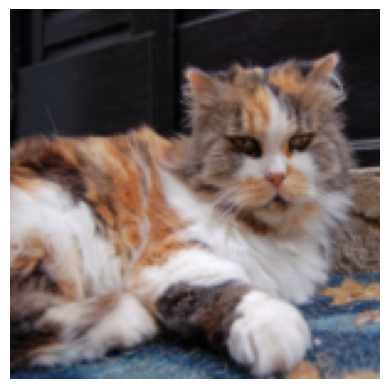

In [201]:
plt.imshow(images[6])
plt.axis('off') 
plt.show()

In [171]:
# Convert images to grayscale
def convert_to_grayscale(images):
    grayscale_images = np.zeros((images.shape[0], images.shape[1], images.shape[2], 1))
    
    for i in range(images.shape[0]):
        grayscale_images[i] = rgb2gray(images[i])[:, :, np.newaxis]
        
    return grayscale_images

# Convert images to grayscale
grayscale_images = convert_to_grayscale(images)

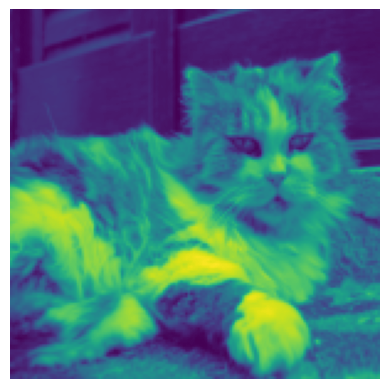

In [202]:
plt.imshow(grayscale_images[6])
plt.axis('off') 
plt.show()

In [172]:
# Data augmentation with tensorflow keras

datagen = ImageDataGenerator(
    rotation_range=20,      # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    shear_range=0.2,        # shear intensity (shear angle in radians)
    zoom_range=0.4,         # range for random zoom
    horizontal_flip=True,   # randomly flip images horizontally
    vertical_flip=False,    # randomly flip images vertically
    fill_mode='nearest'     # filling mode for pixel values outside the input boundaries
)


# Lists
augmented_images = []
augmented_labels = []

# Iterate through each image and label
for image, label in zip(images, target):
    # Reshape the image to (1, height, width, channels) as required by flow()
    image = np.expand_dims(image, axis=0)
    
    # Generate augmented images
    augmented_image_generator = datagen.flow(image, batch_size=1)
    
    # Generate multiple augmented images from the generator
    for _ in range(8):  # Adjust the number of augmented images generated per original image
        augmented_image = augmented_image_generator.next()[0]
        augmented_images.append(augmented_image)
        augmented_labels.append(label)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


In [173]:
print("Shape of augmented images array:", augmented_images.shape)

Shape of augmented images array: (1120, 150, 150, 3)


In [174]:
# Generate pandas Data Frame with labels

aug_images = []

for i in augmented_images:
    
    aug_images.append(i.flatten())

flat_aug_images = np.array(aug_images)
target = np.array(augmented_labels)

df = pd.DataFrame(flat_aug_images)
df['Target'] = target

In [200]:
df.shape

(1120, 67501)

In [175]:
df["Target"].value_counts()

1    576
0    544
Name: Target, dtype: int64

## Model Selection

In [176]:
target_var = 'Target'

X = df.drop(columns = target_var)
y = df[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)


scaler = StandardScaler()

ml_models = [LogisticRegression(max_iter=1000), 
             DecisionTreeClassifier(),
             RandomForestClassifier(n_jobs= -1), 
             SVC(),
             KNeighborsClassifier(n_jobs= -1)
            ]

for model in ml_models:
    
    pipe = make_pipeline(scaler, model)
    grid = GridSearchCV(estimator= pipe, param_grid= {}, cv= 5, scoring= "accuracy")
    grid.fit(X_train, y_train)
    
    print(f" Training scores for {model}") 
    print(f"\tBest Score: {grid.best_score_}")
    print(f"\tCV Score: {grid.cv_results_}")
    print("")    

 Training scores for LogisticRegression(max_iter=1000)
	Best Score: 0.6986530105524519
	CV Score: {'mean_fit_time': array([4.22365198]), 'std_fit_time': array([0.37165953]), 'mean_score_time': array([0.43781829]), 'std_score_time': array([0.0241205]), 'params': [{}], 'split0_test_score': array([0.70555556]), 'split1_test_score': array([0.65921788]), 'split2_test_score': array([0.72067039]), 'split3_test_score': array([0.66480447]), 'split4_test_score': array([0.74301676]), 'mean_test_score': array([0.69865301]), 'std_test_score': array([0.03225339]), 'rank_test_score': array([1])}

 Training scores for DecisionTreeClassifier()
	Best Score: 0.7165176908752328
	CV Score: {'mean_fit_time': array([52.06942301]), 'std_fit_time': array([7.17434323]), 'mean_score_time': array([0.33653655]), 'std_score_time': array([0.02252686]), 'params': [{}], 'split0_test_score': array([0.71666667]), 'split1_test_score': array([0.73743017]), 'split2_test_score': array([0.74301676]), 'split3_test_score': arr

In [178]:
model_scores = {"LogisticRegression": 0.6986530105524519,
               "DecisionTreeC": 0.7165176908752328,
               "RandomForestC": 0.8861762880198635,
               "SVC": 0.8348168839230292,
               "KNeighborsC": 0.5948789571694599}

In [179]:
model_scores_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'Accuracy'])
model_scores_df = model_scores_df.sort_values(by='Accuracy', ascending=False)
model_scores_df["Accuracy"] = round(model_scores_df["Accuracy"] * 100, 1)
model_scores_df

,Model,Accuracy
2,RandomForestC,88.6
3,SVC,83.5
1,DecisionTreeC,71.7
0,LogisticRegression,69.9
4,KNeighborsC,59.5


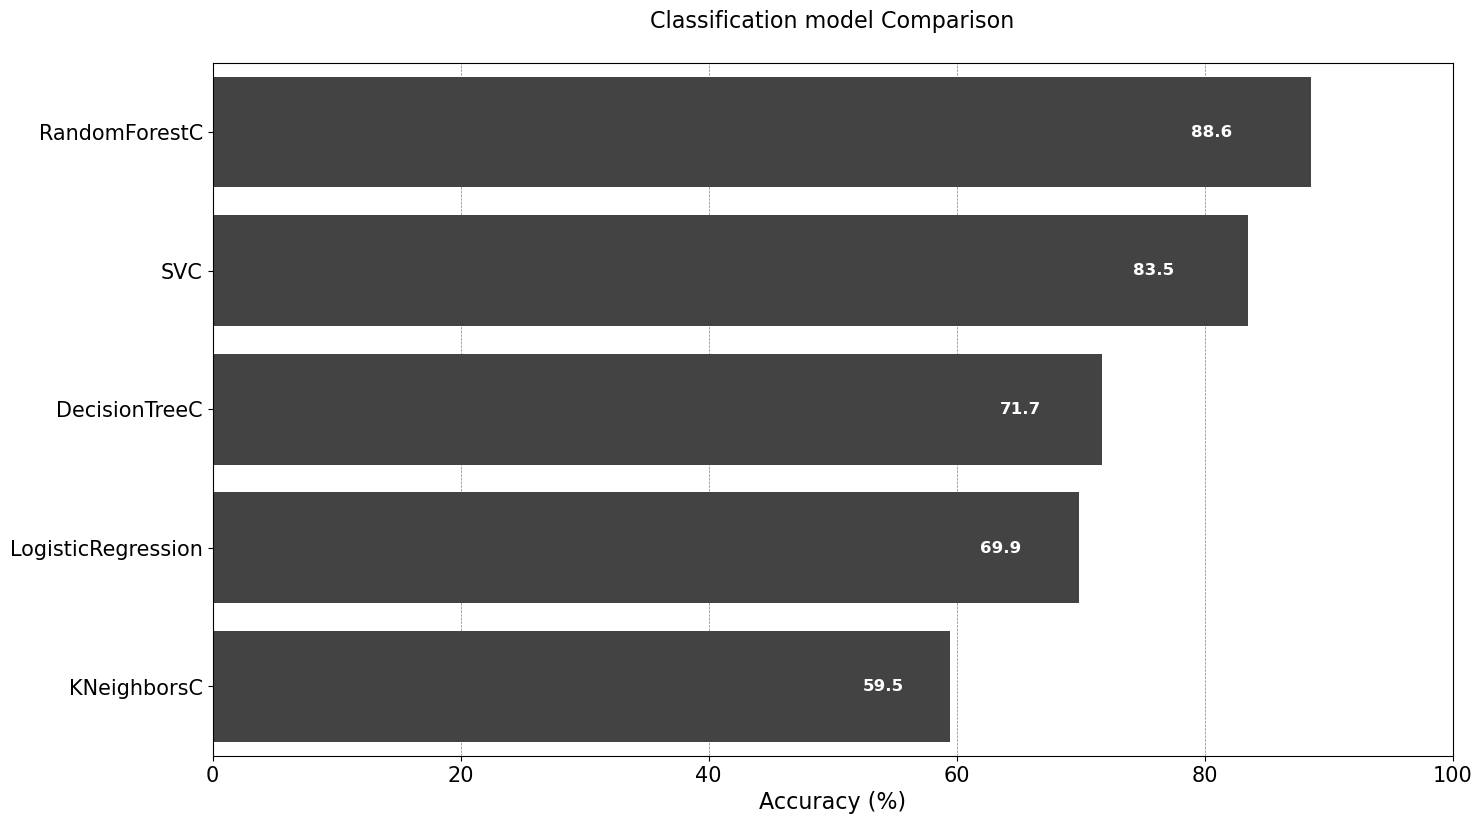

In [180]:
plt.figure(figsize=(16,9))  

sns.set_palette(['#434343'])

ax = sns.barplot(data=model_scores_df, y="Model", x="Accuracy")


# Set the xlabel
ax.set_xlabel("Accuracy (%)", size = 16)
# Extend x-axis from 0 to 100
ax.set_xlim(0, 100)

# Remove ylabel
ax.set_ylabel("")

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

# Add text inside the bar and make it white
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{width:.1f}', (x + width/1.1, y + height/2), 
                ha='center', va='center', color='white', weight='bold', size = 12)
    
for x_coord in ax.get_xticks():
    ax.axvline(x=x_coord, color='gray', linestyle='--', linewidth=0.5, zorder=0)  
    
plt.title("Classification model Comparison\n", size = 16)

plt.savefig("tuxedo_model_selection.png", dpi=300)

## Random Forest Classification

In [182]:
scaler = StandardScaler()



param_grid_rf = {'randomforestclassifier__min_samples_leaf': [1, 0.5, 2],
                 'randomforestclassifier__n_estimators': [100, 200, 400],
                 'randomforestclassifier__max_depth': [None, 10, 50]
    
}

clf = RandomForestClassifier(n_jobs= -1)

pipe = make_pipeline(scaler, clf)

grid_rf = GridSearchCV(estimator= pipe, param_grid= param_grid_rf, cv= 5, scoring= "accuracy")

grid_rf.fit(X_train, y_train)

print(f"Best score: {grid_rf.best_score_}")
print(f"Best params: {grid_rf.best_params_}")



Best score: 0.8895220360024829
Best params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 400}


In [183]:
rf = grid_rf.best_estimator_

In [184]:
y_pred = rf.predict(X_test)

In [185]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix


Classification report of model:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       106
           1       0.93      0.94      0.94       118

    accuracy                           0.93       224
   macro avg       0.93      0.93      0.93       224
weighted avg       0.93      0.93      0.93       224

Accuracy score: 93.30357142857143


<Figure size 600x600 with 0 Axes>

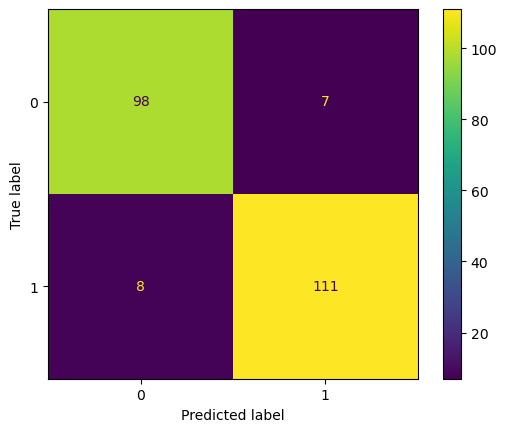

In [195]:
plt.figure(figsize=(6, 6))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)


print("\nClassification report of model:\n",classification_report(y_pred,y_test))
print("Accuracy score:",100*accuracy_score(y_pred,y_test))

plt.savefig("cm_matrix.png")

plt.show()

In [189]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       106
           1       0.93      0.94      0.94       118

    accuracy                           0.93       224
   macro avg       0.93      0.93      0.93       224
weighted avg       0.93      0.93      0.93       224



In [111]:
confusion_matrix(y_pred,y_test)

array([[23,  1],
       [ 6, 26]], dtype=int64)

## Save ML model and validate with new images

In [196]:
import pickle

In [197]:
pickle.dump(rf,open("Tuxedo_Model.p","wb"))

In [198]:
tuxedo_model = pickle.load(open("Tuxedo_Model.p","rb"))

Enter url of image to test: file:///C:/Users/davwul/Downloads/tuxedo-cat-916335_1920-5b4f727946e0fb00376619f6.jpg
Dimensions of original image are: (1622, 1920, 3)
PREDICTED OUTPUT IS: tuxedo_cats


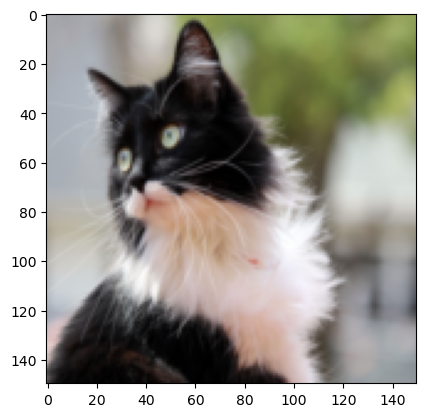

In [199]:
# Testing for a new image
flat_data = []
url = input ('Enter url of image to test: ')
img_array = imread(url)
# Resize image
img_resized = resize(img_array,(150,150,3))
flat_data.append(img_resized.flatten())
flat_data = np.array(flat_data)
print("Dimensions of original image are:",img_array.shape)
plt.imshow(img_resized)
y_output = tuxedo_model.predict(flat_data)
y_output = Categories[y_output[0]]

print("PREDICTED OUTPUT IS:",y_output)

Enter url of image to test: file:///C:/Users/davwul/Downloads/katt-ber.jpg
Dimensions of original image are: (998, 800, 3)
PREDICTED OUTPUT IS: other_cats


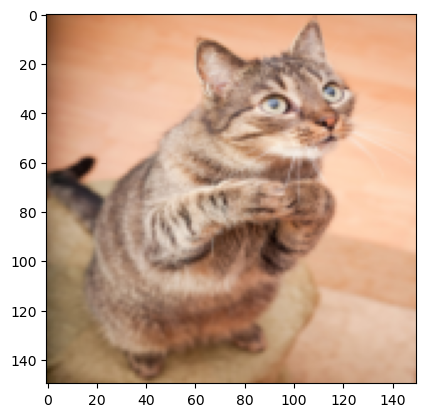

In [127]:
# Testing for a new image
flat_data = []
url = input ('Enter url of image to test: ')
img_array = imread(url)
# Resize image
img_resized = resize(img_array,(150,150,3))
flat_data.append(img_resized.flatten())
flat_data = np.array(flat_data)
print("Dimensions of original image are:",img_array.shape)
plt.imshow(img_resized)
y_output = tuxedo_model.predict(flat_data)
y_output = Categories[y_output[0]]

print("PREDICTED OUTPUT IS:",y_output)